In [1]:
import numpy as np
import sounddevice as sd
import soundfile as sf
from numpy import ndarray
from numpy.fft import fft, ifft, rfft, hfft
from scipy.signal import butter, lfilter, freqz, firwin2, unit_impulse, sosfilt
from shared.record_signal import convert_audio_to_numpy_array
import matplotlib.pyplot as plt

import IPython.display as ipd

In [2]:
recording_count = 10
fs = 44100

In [3]:
hd600_audios = []

for i in range(recording_count):
    audio, fs = convert_audio_to_numpy_array(f"../HPIRs_Erbes_44100Hz/Measurements/HD600/pass0{i}.wav")
    hd600_audios.append(audio)

In [4]:
n_input = hd600_audios[0].shape[0]
print('Number of Input steps:\t', n_input)

Number of Input steps:	 17640


In [5]:
hd600_fft = []

for audio in hd600_audios:
    y_l = audio[:, 0]
    y_r = audio[:, 1]
    Y_L = fft(y_l)
    Y_R = fft(y_r)
    Y_fft = np.append([Y_L], [Y_R], axis = 0)
    Y_fft = Y_fft.transpose()
    hd600_fft.append(Y_fft)

In [6]:
n_output = hd600_fft[0].shape[0]
print('Number of output points:\t\t', n_output)
n_output_one_sided = int(n_output / 2 + 1)
print("Number of output points (one-sided):\t", n_output_one_sided)

Number of output points:		 17640
Number of output points (one-sided):	 8821


In [7]:
hd600_fft_mean = []
Y_L_fft_sum = np.empty([n_output])
Y_R_fft_sum = np.empty([n_output])

for Y in hd600_fft:
    Y_L_fft_sum = Y_L_fft_sum + Y[:, 0]
    Y_R_fft_sum = Y_R_fft_sum + Y[:, 1]

Y_L_complex_mean = Y_L_fft_sum / recording_count
Y_R_complex_mean = Y_R_fft_sum / recording_count

Y_complex_mean = np.append([Y_L_complex_mean], [Y_R_complex_mean], axis = 0)

In [121]:
def viz_spectrum(recording, n, ax1_title, ax2_title, fs=44100):
    f_vec = np.linspace(0, fs/2, n)
    left_channel = recording[0, :][: n]
    right_channel = recording[1, :][: n]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2), sharex=True)

    ax1.set_title(ax1_title)
    ax2.set_title(ax2_title)

    ax1.set_xlabel("Frequency [Hz]")
    ax2.set_xlabel("Frequency [Hz]")

    ax1.semilogx(f_vec, 20*np.log10(np.abs(left_channel)))
    ax2.semilogx(f_vec, 20*np.log10(np.abs(right_channel)))

    ax1.set_xlim([20, fs/2])
    ax1.set_ylim(-60, 30)
    ax2.set_xlim([20, fs/2])
    ax2.set_ylim(-60, 30)

    fig.show()

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_11652/563957011.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


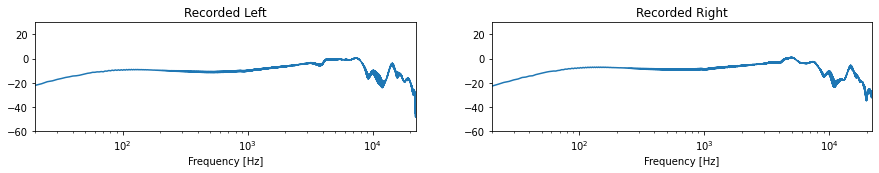

In [122]:
viz_spectrum(Y_complex_mean, n_output_one_sided, 'Recorded Left', 'Recorded Right')

### Design Bandpass Filter

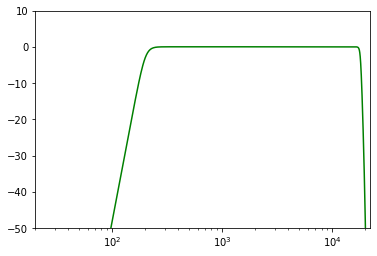

In [123]:
## make fir filter by pushing a dirac through a butterworth SOS (multiple times)

# filter paramters
high_cut = 18000 
low_order = 8
low_cut = 200
high_order = 8

low_pass_filter = high_pass_filter = unit_impulse(n_output)

# lowpass
sos_low_pass = butter(low_order, high_cut, 'lowpass', fs=fs, output='sos')
low_pass_filter = sosfilt(sos_low_pass, low_pass_filter)
low_pass_filter = fft(low_pass_filter)

# highpass
sos_hp = butter(high_order, low_cut, 'highpass', fs=fs, output='sos')
high_pass_filter = sosfilt(sos_hp, high_pass_filter)
high_pass_filter = fft(high_pass_filter)

bandlimit_filter = high_pass_filter * low_pass_filter

#plot
plt.semilogx(f_vec_one_sided, 20*np.log10(np.abs(bandlimit_filter[: n_output_one_sided])), color='green')
plt.xlim([20, fs/2])
plt.ylim([-50, 10]);


Apply Bandpass Filter to L|R channels

In [124]:
# This is with the second one - works properly

Y_L_bandpassed = bandlimit_filter * Y_complex_mean[0]
Y_R_bandpassed = bandlimit_filter * Y_complex_mean[1]

Y_bandpassed = np.append([Y_L_bandpassed], [Y_R_bandpassed], axis = 0)

Visualize Bandpassed Recording

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_11652/563957011.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


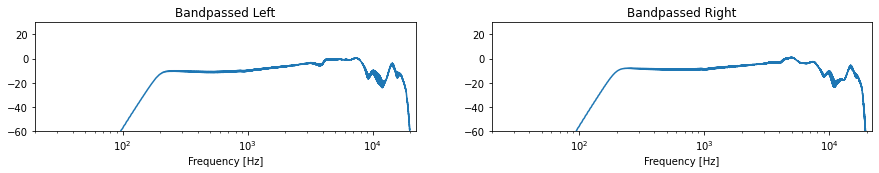

In [125]:
viz_spectrum(Y_bandpassed, n_output_one_sided, 'Bandpassed Left', 'Bandpassed Right')

### Design Regularisation Filter

In [126]:
taps = 51
freqs = [0, 0.2, 0.6, 1]
gain = np.array([-20, -20, 0, 0]).astype(float)
linear_gain = 10**(gain/20)
linear_gain[-1] = 0

In [127]:
b = firwin2(taps, freqs, linear_gain, window=('kaiser', 8))

Compute From Bandpassed Complex Mean

In [128]:
r_L = np.convolve(Y_L_bandpassed, b, 1)
r_R = np.convolve(Y_R_bandpassed, b, 1)

Y_regularised = np.append([r_L], [r_R], axis = 0)

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_11652/563957011.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


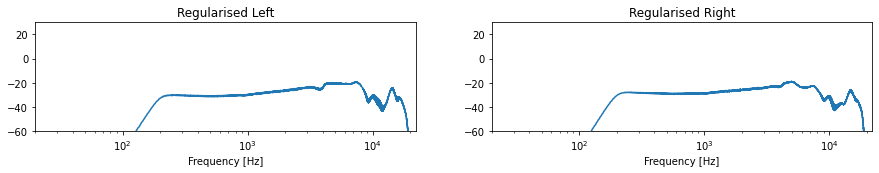

In [129]:
viz_spectrum(Y_regularised, n_output_one_sided, 'Regularised Left', 'Regularised Right')

### Calculate Inverse Filter in Frequency Domain

$hc = [H^{T}H + \beta B^{T}B] * H^{T}d$
- $hc$ -> convolution matrice of measured transfer function
- $H$ -> convolution matrice of measured regularisation filter
- $B$ -> signal vector 
- $d$ -> signal vector (latter denoting the delayed IR of target bandpass filter)
- $\beta$ -> weighting regularisation filter

**Important Note**

$\beta$ has the value of 0.1.

In [130]:
beta = 1

In [131]:
Hc_L = bandlimit_filter.transpose() * np.conj(Y_complex_mean[0]).transpose() / (Y_complex_mean[0].transpose() * np.conj(Y_complex_mean[0]) + beta * r_L.transpose() * np.conj(r_L.transpose()))

In [132]:
Hc_R = bandlimit_filter.transpose() * np.conj(Y_complex_mean[1]).transpose() / (Y_complex_mean[1].transpose() * np.conj(Y_complex_mean[1]) + beta * r_R.transpose() * np.conj(r_R.transpose()))

In [133]:
Y_inversed = np.append([Hc_L], [Hc_R], axis = 0)

Visualize Signal Processed with Compensation Filter

/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_11652/563957011.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


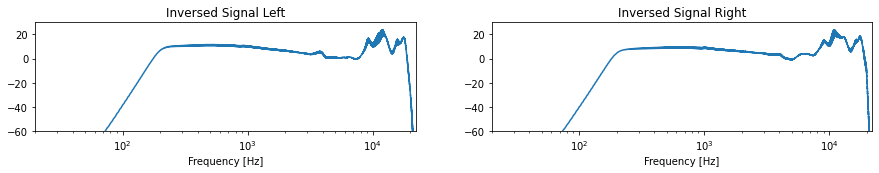

In [134]:
viz_spectrum(Y_inversed, n_output_one_sided, 'Inversed Signal Left', 'Inversed Signal Right')

Transfer Back to Time Domain

In [139]:
hc_l = ifft(Hc_L)
hc_r = ifft(Hc_R)
hc_compensated = np.append([hc_l], [hc_r], axis=0)

In [135]:
def viz_sound(recording, n, title, ax1_title, ax2_title, fs=44100):
    t_vec = np.arange(0, n) / fs
    left_channel = recording[0, :]
    right_channel = recording[1, :]

    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6), sharex='row', sharey='row')
    

    ax1.set_title(ax1_title)
    ax1.set_xlabel('Seconds')
    ax1.set_ylabel("Amplitude")


    ax2.set_title(ax2_title)
    ax2.set_xlabel('Seconds')
    ax2.set_ylabel("Amplitude")

    ax1.plot(t_vec, left_channel)
    ax2.plot(t_vec, right_channel)

    ax1.set_xlim([0.0, 0.005])
    ax1.set_ylim([-1.8, 1.0])
    ax2.set_xlim([0.0, 0.005])
    ax2.set_ylim([-1.8, 1.0])

    fig.suptitle(title, fontsize=16)

    fig.show()

/Users/alpargur/Library/Mobile Documents/com~apple~CloudDocs/Uni/Semester-2/VAE/Project/vae-22-project/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/lj/y568v46x457chtc567j63kzm0000gn/T/ipykernel_11652/1123869353.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


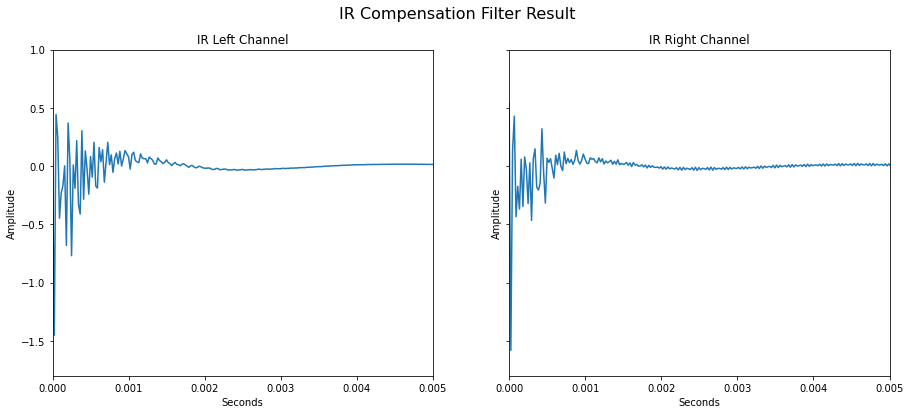

In [140]:
viz_sound(hc_compensated, n_output, 'IR Compensation Filter Result', 'IR Left Channel', 'IR Right Channel')

In [141]:
ipd.Audio(hc_compensated, rate=fs)

/Users/alpargur/Library/Mobile Documents/com~apple~CloudDocs/Uni/Semester-2/VAE/Project/vae-22-project/venv/lib/python3.8/site-packages/IPython/lib/display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)
